In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic, get_body_heliographic_stonyhurst)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import eispac
import irispy.io
import pyvista as pv
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   


In [2]:
def plot_map_pizza(ax, maps, cmaps=None, norms=None, xslice=None, yslice=None,
                    text=None, textcoords=(0.05,0.95),text_shadow=True):
    if not isinstance(maps, list):
        ax.imshow(maps, origin='lower')
    else:
        n_maps = len(maps)
        if n_maps == 3:
            maps = [maps[0], maps[1], maps[0], maps[2]]
            n_maps = 4

        maps_new = []
        if (xslice is not None) and (yslice is not None):
            for map_ in maps:
                maps_new.append(map_.submap([xslice[0],yslice[0]]*u.pix, 
                                top_right=[xslice[1],yslice[1]]*u.pix))
            maps = maps_new

        if n_maps == 1:
            if cmaps is not None:
                cmap = cmaps[0]
            else:
                cmap = maps[0].plot_settings['cmap']
            cmap = plt.get_cmap(cmap)

            if norms is not None:
                norm = norms[0]
            else:
                norm = maps[0].plot_settings['norm']
            ax.imshow(cmap(norm(maps[0].data)), origin='lower', aspect=maps[0].scale.axis2/maps[0].scale.axis1)
        else:
            map_shape = maps[0].data.shape
            pizza_array = np.zeros(map_shape + (4,))
            if n_maps == 2:
                sub_map_shape = (map_shape[0], map_shape[1]//2)
                for ii, map_ in enumerate(maps):
                    if cmaps is not None:
                        cmap = cmaps[ii]
                    else:
                        cmap = map_.plot_settings['cmap']
                    if isinstance(cmap, str):
                        cmap = plt.get_cmap(cmap)

                    if norms is not None:
                        norm = norms[ii]
                    else:
                        norm = map_.plot_settings['norm']

                    pizza_array[:,ii%2*sub_map_shape[1]:(ii%2 + 1)*sub_map_shape[1],:] = cmap(norm(map_.data[:,ii%2*sub_map_shape[1]:(ii%2 + 1)*sub_map_shape[1]]))
            
            elif n_maps == 4:
                sub_map_shape = (map_shape[0]//2, map_shape[1]//2)
                for ii, map_ in enumerate(maps):
                    if cmaps is not None:
                        cmap = cmaps[ii]
                    else:
                        cmap = map_.plot_settings['cmap']
                    cmap = plt.get_cmap(cmap)

                    if norms is not None:
                        norm = norms[ii]
                    else:
                        norm = map_.plot_settings['norm']

                    pizza_array[ii//2*sub_map_shape[0]:(ii//2 + 1)*sub_map_shape[0],ii%2*sub_map_shape[1]:(ii%2 + 1)*sub_map_shape[1],:] \
                        = cmap(norm(map_.data[ii//2*sub_map_shape[0]:(ii//2 + 1)*sub_map_shape[0],ii%2*sub_map_shape[1]:(ii%2 + 1)*sub_map_shape[1]]))

            ax.imshow(pizza_array, origin='lower', aspect=maps[0].scale.axis2/maps[0].scale.axis1)

    if text is not None:
        text_obj = ax.text(textcoords[0], textcoords[1], text, fontsize=10, color='white', ha='left', va='top',
        transform=ax.transAxes)

        # box=dict(facecolor='white', edgecolor='#91989F', alpha=0.3,
        #         boxstyle='round,pad=0.5')
        
        if text_shadow:
            text_obj.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
    ax.axis('off')

In [3]:
def arrow_connect(ax1, ax2, x_nodes, y_nodes, text_coords, text, color='black', 
                textrotation=0.,arrow_1=False, arrow_2=True,):
    
    n_nodes = len(x_nodes)

    if n_nodes == 2:
        if arrow_1 is False and arrow_2 is True:
            arrow_style = '-|>'
        elif arrow_1 is True and arrow_2 is False:
            arrow_style = '<|-'
        elif arrow_1 is False and arrow_2 is False:
            arrow_style = '-'
        else:
            arrow_style = '<|-|>'
        ax1.annotate('', xy=(x_nodes[1], y_nodes[1]), xytext=(x_nodes[0], y_nodes[0]),
        xycoords=ax2.transAxes, textcoords=ax1.transAxes, 
        arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_style, shrinkA=0, shrinkB=0)) 
    
    if n_nodes > 2:
        arrow_style_1 = '<|-' if arrow_1 is True else '-'
        arrow_style_2 = '-|>' if arrow_2 is True else '-'
        arrow_styles = [arrow_style_1] + ['-']*(n_nodes-2) + [arrow_style_2]

        for ii in range(n_nodes-2):
            ax1.annotate('', xy=(x_nodes[ii+1], y_nodes[ii+1]), xytext=(x_nodes[ii], y_nodes[ii]),
            xycoords=ax1.transAxes, textcoords=ax1.transAxes,
            arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_styles[ii], shrinkA=0, shrinkB=0))
        
        ax1.annotate('', xy=(x_nodes[-1], y_nodes[-1]), xytext=(x_nodes[-2], y_nodes[-2]),
            xycoords=ax2.transAxes, textcoords=ax1.transAxes,
            arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_styles[-1], shrinkA=0, shrinkB=0))

    ax1.text(text_coords[0], text_coords[1], text, fontsize=10, color='black', ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=1,
                boxstyle='round,pad=0.3'), transform=ax1.transAxes, rotation=textrotation)





In [4]:
aia_193_map_eis = sunpy.map.Map("../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.193.image.fits")
aia_193_map = sunpy.map.Map("../../src/AIA/20221024/193/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.193.image.fits")
aia_193_map_eis_hh = sunpy.map.Map("../../src/AIA/20221024/193/lvl15/aia.lev1_euv_12s.2022-10-24T193851Z.193.image.fits")
aia_193_map_2322 = sunpy.map.Map("../../src/AIA/20221024/193/lvl15/aia.lev1_euv_12s.2022-10-24T232251Z.193.image.fits")

aia_193_map_eis_crop = aia_193_map_eis.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map_eis.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map_eis.coordinate_frame))

aia_193_map_eis_hh_crop = aia_193_map_eis_hh.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map_eis_hh.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map_eis_hh.coordinate_frame))

aia_193_map_crop = aia_193_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map.coordinate_frame))

aia_193_map_2322_crop = aia_193_map_2322.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map_2322.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map_2322.coordinate_frame))


aia_171_map = sunpy.map.Map("../../src/AIA/20221024/171/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.171.image.fits")

aia_171_map_crop = aia_171_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_171_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_171_map.coordinate_frame))

aia_171_map_eis = sunpy.map.Map("../../src/AIA/20221025/171/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.171.image.fits")

aia_171_map_eis_crop = aia_171_map_eis.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_171_map_eis.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_171_map_eis.coordinate_frame))



aia_304_map = sunpy.map.Map("../../src/AIA/20221024/304/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.304.image.fits")

aia_304_map_crop = aia_304_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_304_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_304_map.coordinate_frame))

aia_1600_map = sunpy.map.Map("../../src/AIA/20221024/1600/lvl15/aia.lev1_uv_24s.2022-10-24T191951Z.1600.image.fits")

aia_1600_map_crop = aia_1600_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_1600_map.coordinate_frame), 
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_1600_map.coordinate_frame))

aia_1700_map = sunpy.map.Map("../../src/AIA/20221024/1700/lvl15/aia.lev1_uv_24s.2022-10-24T191951Z.1700.image.fits")

aia_1700_map_crop = aia_1700_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_1700_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_1700_map.coordinate_frame))

aia_1700_map_2322 = sunpy.map.Map("../../src/AIA/20221024/1700/lvl15/aia.lev1_uv_24s.2022-10-24T232303Z.1700.image.fits")
aia_1700_map_2322_crop = aia_1700_map_2322.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_1700_map_2322.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_1700_map_2322.coordinate_frame))


In [5]:
hri_174_map_shifted_toaia = sunpy.map.Map("../../src/coalign_map/20221024/hri_174_map_shifted_toaia.fits")

In [6]:
fsi_174_map_hri_time_shift = sunpy.map.Map("../../src/coalign_map/20221024/fsi_174_map_hri_time_shift.fits")
fsi_304_map_hri_time_shift = sunpy.map.Map("../../src/coalign_map/20221024/fsi_304_map_hri_time_shift.fits")
fsi_304_map_hri_time_shift.plot_settings['cmap'] = "solar orbiterfsi304"
fsi_304_map_hri_time_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.05))

In [7]:
fsi_174_map_hri_time_shift_crop = fsi_174_map_hri_time_shift.submap(SkyCoord(500*u.arcsec,0*u.arcsec,frame=fsi_174_map_hri_time_shift.coordinate_frame),
                                    top_right=SkyCoord(2000*u.arcsec,1250*u.arcsec,frame=fsi_174_map_hri_time_shift.coordinate_frame))
fsi_304_map_hri_time_shift_crop = fsi_304_map_hri_time_shift.submap(SkyCoord(500*u.arcsec,0*u.arcsec,frame=fsi_304_map_hri_time_shift.coordinate_frame),
                                    top_right=SkyCoord(2000*u.arcsec,1250*u.arcsec,frame=fsi_304_map_hri_time_shift.coordinate_frame))

In [8]:
phi_los_map_shifted = sunpy.map.Map("../../src/coalign_map/20221024/phi_los_map_shifted.fits")
phi_los_map_shifted.plot_settings['cmap'] = "hmimag"
phi_los_map_shifted.plot_settings['norm'] = ImageNormalize(vmin=-1000,vmax=1000)

In [9]:
hmi_los_map = sunpy.map.Map("../../src/HMI/20221024/lvl15/hmi.M_45s.20221024_192100_TAI.2.magnetogram.fits")
hmi_los_map_to_aia = hmi_los_map.reproject_to(aia_193_map.wcs)
hmi_los_map_crop = hmi_los_map_to_aia.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=hmi_los_map_to_aia.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=hmi_los_map_to_aia.coordinate_frame))

In [10]:
spice_NeVIII_intmap_derot_shift = sunpy.map.Map("../../src/coalign_map/20221024/spice_NeVIII_intmap_derot_shift.fits")
spice_NeVIII_intmap_derot_shift.plot_settings['cmap'] = "sohoeit171"
spice_NeVIII_intmap_derot_shift.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=10,stretch=AsinhStretch(0.01))

spice_NeVIII_velmap_derot_shift = sunpy.map.Map("../../src/coalign_map/20221024/spice_NeVIII_velmap_derot_shift.fits")
spice_NeVIII_velmap_derot_shift.plot_settings['cmap'] = "coolwarm"
spice_NeVIII_velmap_derot_shift.plot_settings['norm'] = ImageNormalize(vmin=-40,vmax=40,)

In [11]:
fsi_174_map = sunpy.map.Map("../../src/EUI/FSI/euv174/20221024/solo_L2_eui-fsi174-image_20221024T192050179_V01.fits")
fsi_304_map = sunpy.map.Map("../../src/EUI/FSI/euv304/20221024/solo_L2_eui-fsi304-image_20221024T192020179_V01.fits")

In [12]:
eis_195_intmap_shift = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_intmap_shift.fits")
eis_195_velmap_shift = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_shift.fits")
eis_195_intmap_shift.plot_settings['cmap'] = plt.get_cmap("hinodexrt").reversed()
eis_195_intmap_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.4))
eis_195_velmap_shift.plot_settings['cmap'] = "coolwarm"
eis_195_velmap_shift.plot_settings['norm'] = ImageNormalize(vmin=-15,vmax=15,)

In [13]:
eis_hhflare_195_intmap_shift = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_intmap_shift.fits")
eis_hhflare_195_intmap_shift.plot_settings['cmap'] = plt.get_cmap("hinodexrt").reversed()
eis_hhflare_195_intmap_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.4))
eis_hhflare_195_velmap_shift = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_shift.fits")
eis_hhflare_195_velmap_shift.plot_settings['cmap'] = "coolwarm"
eis_hhflare_195_velmap_shift.plot_settings['norm'] = ImageNormalize(vmin=-15,vmax=15,)

In [14]:
# fake VBI image from screenshot, will be replaced by real VBI data in the future
from PIL import Image

vbi_Halpha = np.asarray(Image.open("../../figs/fake_VBI/Halpha.png"))
vbi_CaIIK = np.asarray(Image.open("../../figs/fake_VBI/CaIIK.png"))
vbi_TiO = np.asarray(Image.open("../../figs/fake_VBI/TiO.png"))
vbi_Gband = np.asarray(Image.open("../../figs/fake_VBI/Gband.png"))

vbi_combined = np.zeros((800,800,4),dtype=np.uint8)
vbi_combined[:400,:400,:] = vbi_Halpha[200:600,200:600,:]
vbi_combined[:400,400:,:] = vbi_CaIIK[200:600,600:1000,:]
vbi_combined[400:,:400,:] = vbi_TiO[600:1000,200:600,:]
vbi_combined[400:,400:,:] = vbi_Gband[600:1000,600:1000,:]

In [15]:
chase_halpha_core_map_align_shift = sunpy.map.Map("../../src/coalign_map/20221024/chase_halpha_core_map_align_shift.fits")
chase_halpha_core_map_align_shift.plot_settings['cmap'] = "afmhot"
chase_halpha_line_width_map_align_shift = sunpy.map.Map("../../src/coalign_map/20221024/chase_halpha_line_width_map_align_shift.fits")
chase_halpha_line_width_map_align_shift.plot_settings['cmap'] = "plasma"
chase_halpha_line_width_map_align_shift.plot_settings['norm'] = ImageNormalize(vmin=0.9,vmax=1.35)

In [16]:
dkist_fitv_tom_cont_int_map_shift = sunpy.map.Map("../../src/coalign_map/20221024/dkist_fitv_tom_cont_int_map_shift.fits")
dkist_fitv_tom_cont_int_map_shift.plot_settings['cmap'] = "irissji2796"
dkist_fitv_tom_cont_int_map_shift.plot_settings['norm'] = ImageNormalize(vmin=0.6,vmax=1.05,stretch=LinearStretch())
dkist_fitv_tom_btot_map_shift = sunpy.map.Map("../../src/coalign_map/20221024/dkist_fitv_tom_btot_map_shift.fits")
dkist_fitv_tom_btot_map_shift.plot_settings['cmap'] = "plasma"
dkist_fitv_tom_btot_map_shift.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=2e3,stretch=PowerStretch(0.5))
dkist_ftiv_tom_theta_map_shifted_masked = sunpy.map.Map("../../src/coalign_map/20221024/dkist_fitv_tom_theta_map_shifted_masked.fits")
dkist_ftiv_tom_theta_map_shifted_masked.plot_settings['cmap'] = "twilight_shifted"
dkist_ftiv_tom_theta_map_shifted_masked.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=180,stretch=LinearStretch())
dkist_fitv_tom_DoppVel_map_shifted = sunpy.map.Map("../../src/coalign_map/20221024/dkist_fitv_tom_DoppVel_map_shifted.fits")
dkist_fitv_tom_DoppVel_map_shifted.plot_settings['cmap'] = "coolwarm"
dkist_fitv_tom_DoppVel_map_shifted.plot_settings['norm'] = ImageNormalize(vmin=-2.5,vmax=2.5,stretch=LinearStretch())

In [17]:
iris_1400_sji_2322_map_rotate_crop_shift = sunpy.map.Map("../../src/coalign_map/20221024/iris_1400_sji_2322_0_map_rotate_crop_shift.fits")
iris_1400_sji_2322_map_rotate_crop_shift.plot_settings['cmap'] = "irissji1400"
iris_1400_sji_2322_map_rotate_crop_shift.plot_settings['norm'] = ImageNormalize(vmin=10,vmax=2e2,stretch=AsinhStretch(0.1))

In [18]:
iris_SiIV_1394_intmap_rotate_shift_2322 = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/iris_SiIV_1394_intmap_rotate_shift.fits")
iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji = iris_SiIV_1394_intmap_rotate_shift_2322.reproject_to(iris_1400_sji_2322_map_rotate_crop_shift.wcs)
iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji.plot_settings['cmap'] = "irissjiFUV"
iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=1e4,stretch=AsinhStretch(0.1))
iris_SiIV_1394_velmap_rotate_shift_2322 = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/iris_SiIV_1394_velmap_rotate_shift.fits")
iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji = iris_SiIV_1394_velmap_rotate_shift_2322.reproject_to(iris_1400_sji_2322_map_rotate_crop_shift.wcs)
iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji.plot_settings['cmap'] = "coolwarm"
iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji.plot_settings['norm'] = ImageNormalize(vmin=-30,vmax=30)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


In [19]:
iris_1400_sji_1920_map_rotate_shift = sunpy.map.Map("../../src/coalign_map/20221024/iris_1400_sji_1920_map_rotate_shift.fits")
iris_1400_sji_1920_map_rotate_shift.plot_settings['cmap'] = "irissji1400"
iris_1400_sji_1920_map_rotate_shift.plot_settings['norm'] = ImageNormalize(vmin=-1,vmax=20,stretch=AsinhStretch(0.1))

In [20]:
aia_193_map_0220_synthetic_raster = np.load("../../src/EIS/eis_pointing/eis_20221025_014811/cache/synthetic_raster_20221025_014811.npy")

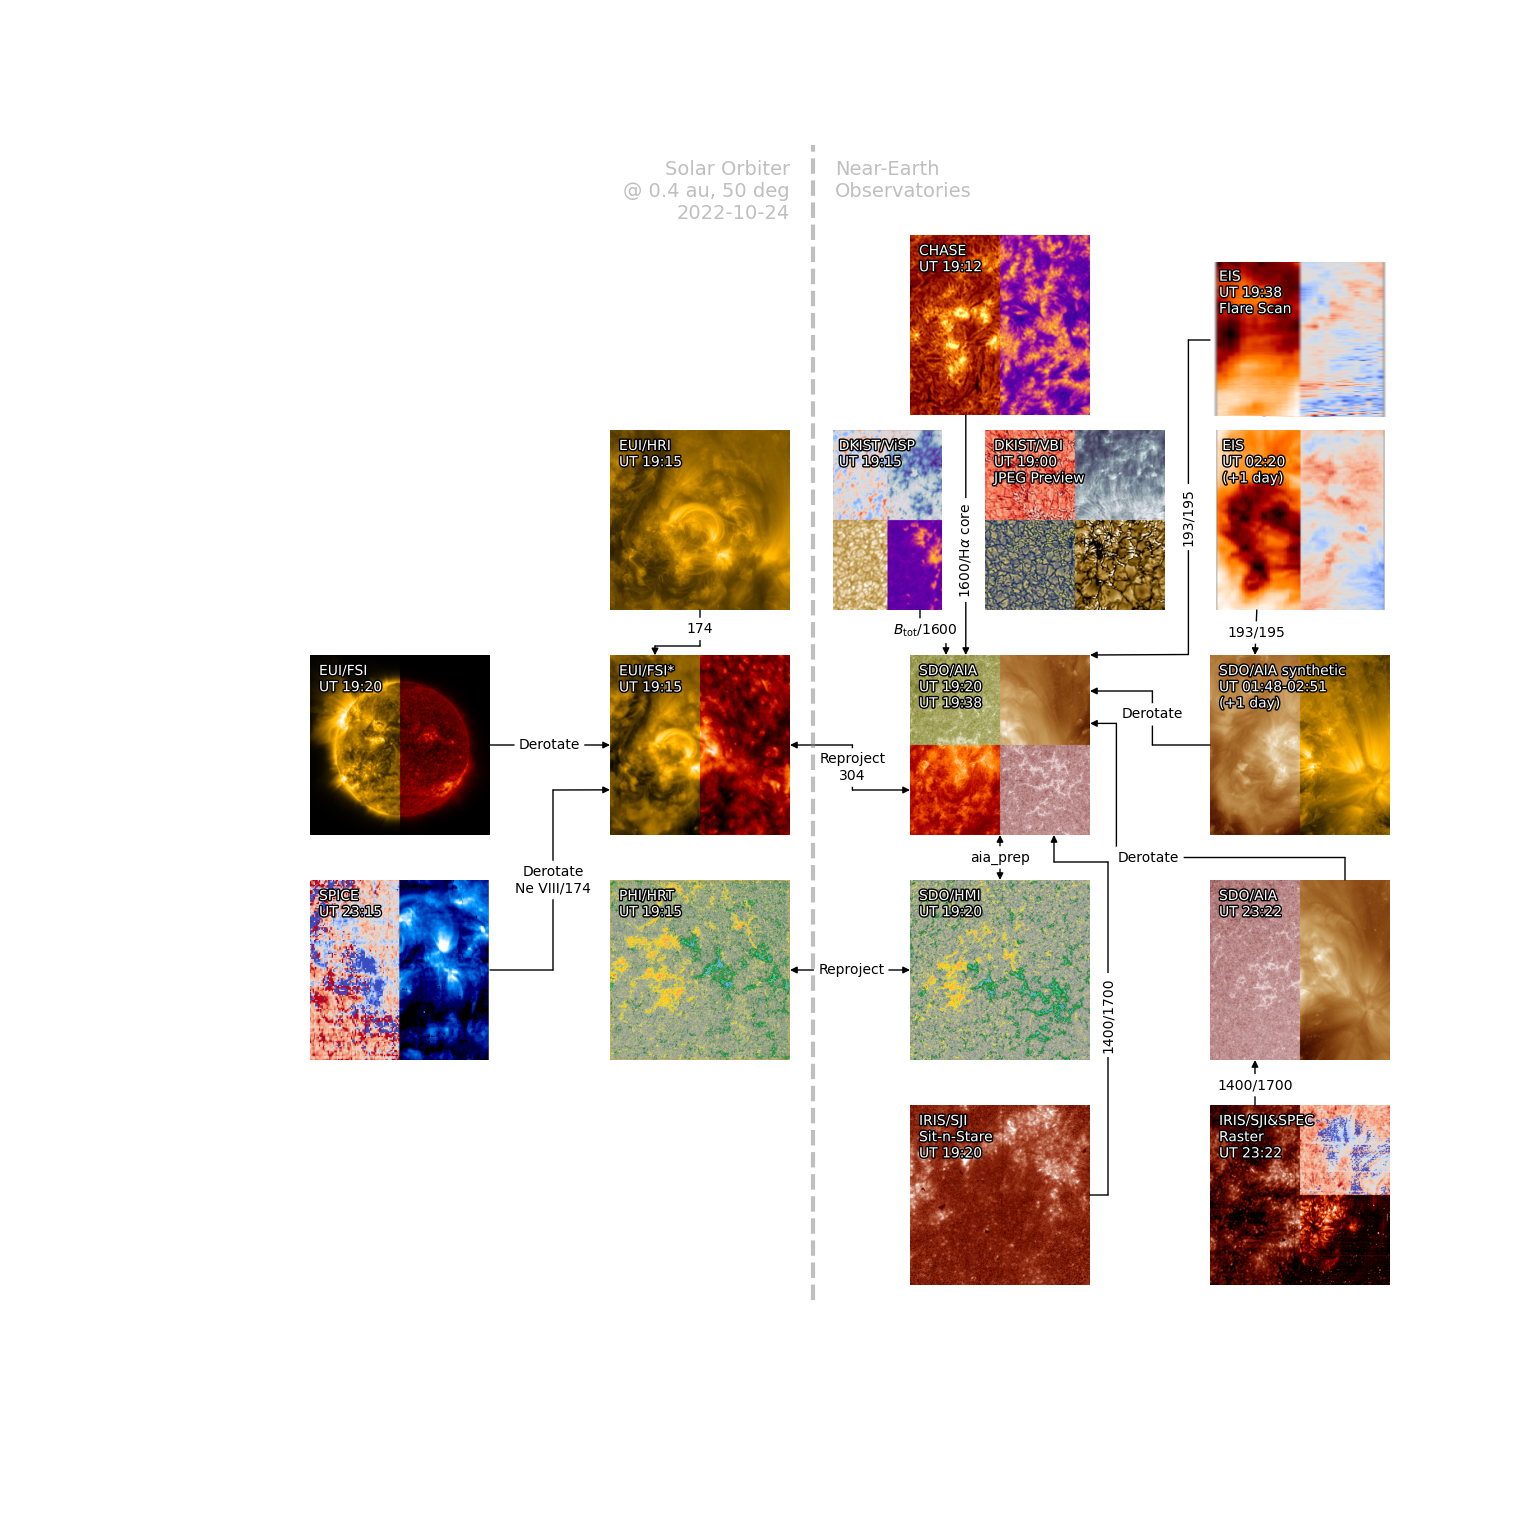

In [21]:
fig = plt.figure(figsize=(15,15))

ax_aia_1920 = fig.add_axes([0.6,0.45,0.12,0.12])
ax_fsi_1915 = fig.add_axes([0.4,0.45,0.12,0.12])
ax_hri_1915 = fig.add_axes([0.4,0.60,0.12,0.12])
ax_phi_1915 = fig.add_axes([0.4,0.3,0.12,0.12])
ax_hmi_1920 = fig.add_axes([0.6,0.3,0.12,0.12])
ax_spice_2315 = fig.add_axes([0.2,0.3,0.12,0.12])
ax_fsi_1920 = fig.add_axes([0.2,0.45,0.12,0.12])
ax_aia_0220 = fig.add_axes([0.8,0.45,0.12,0.12])
ax_aia_2322 = fig.add_axes([0.8,0.3,0.12,0.12])
ax_eis_0220 = fig.add_axes([0.8,0.6,0.12,0.12])
ax_eis_1938 = fig.add_axes([0.8,0.72,0.12,0.12])
ax_chase_1912 = fig.add_axes([0.6,0.73,0.12,0.12])
ax_visp_1915 = fig.add_axes([0.545,0.6,0.08,0.12])
ax_iris_2322 = fig.add_axes([0.8,0.15,0.12,0.12])
ax_iris_1920 = fig.add_axes([0.6,0.15,0.12,0.12])

ax_fig = fig.add_axes([0,0,1,1])
ax_fig.axis('off')

ax_vbi_1900 = fig.add_axes([0.65,0.6,0.12,0.12])
ax_vbi_1900.tick_params(which="major",axis="x",bottom=False,labelbottom=False)
ax_vbi_1900.tick_params(which="major",axis="y",left=False,labelleft=False)
ax_vbi_1900.imshow(vbi_combined)
text_vbi_1900 = ax_vbi_1900.text(0.05,0.95,"DKIST/VBI\nUT 19:00\nJPEG Preview",fontsize=10,color='white',ha='left',va='top',
        transform=ax_vbi_1900.transAxes)
text_vbi_1900.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                          path_effects.Normal()])
ax_vbi_1900.axis('off')


plot_map_pizza(ax_aia_1920, [aia_304_map_crop,aia_1700_map_crop,aia_1600_map_crop,aia_193_map_crop,],
                xslice=[0,799], yslice=[200,999],text='SDO/AIA\nUT 19:20\nUT 19:38')

plot_map_pizza(ax_fsi_1915, [fsi_174_map_hri_time_shift_crop, fsi_304_map_hri_time_shift_crop],
                xslice=[0,299], yslice=[10,349],text='EUI/FSI*\nUT 19:15')

arrow_connect(ax_aia_1920, ax_fsi_1915, [0,-0.32,-0.32,1], [0.25,0.25,0.5,0.5], [-0.32,0.375], 'Reproject\n304', color='black',
                textrotation=0.,arrow_1=True, arrow_2=True)

plot_map_pizza(ax_hri_1915, [hri_174_map_shifted_toaia],
                text='EUI/HRI\nUT 19:15')

arrow_connect(ax_hri_1915, ax_fsi_1915, [0.5,0.5,0.25,0.25], [0,-0.2,-0.2,1], [0.5,-0.105], '174', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_phi_1915, [phi_los_map_shifted],
                text='PHI/HRT\nUT 19:15')

plot_map_pizza(ax_hmi_1920, [hmi_los_map_crop], 
                text='SDO/HMI\nUT 19:20', norms=[ImageNormalize(vmin=-1000,vmax=1000)],
                cmaps=['hmimag'], xslice=[0,799], yslice=[200,999])

arrow_connect(ax_hmi_1920, ax_aia_1920, [0.5,0.5], [1,0], [0.5,1.125], 'aia_prep', color='black',
                textrotation=0.,arrow_1=True, arrow_2=True)

arrow_connect(ax_phi_1915, ax_hmi_1920, [1,0.], [0.5,0.5], [1.34,0.5], 'Reproject', color='black',
                textrotation=0.,arrow_1=True, arrow_2=True)

plot_map_pizza(ax_spice_2315, [spice_NeVIII_velmap_derot_shift,spice_NeVIII_intmap_derot_shift],
                text='SPICE\nUT 23:15', xslice=[40,180], yslice=[45,185])

plot_map_pizza(ax_fsi_1920, [fsi_174_map, fsi_304_map],
                text='EUI/FSI\nUT 19:20', xslice=[500,1999], yslice=[700,2199])

arrow_connect(ax_fsi_1920, ax_fsi_1915, [1,0], [0.5,0.5], [1.33,0.5], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

arrow_connect(ax_spice_2315, ax_fsi_1915, [1,1.35,1.35,0], [0.5,0.5,1.5,0.5-0.25], [1.35,1], 'Derotate\nNe VIII/174', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_aia_0220, [aia_193_map_eis_crop, aia_171_map_eis_crop],
                text='SDO/AIA synthetic\nUT 01:48-02:51\n(+1 day)', xslice=[0,799], yslice=[200,999])

arrow_connect(ax_aia_0220, ax_aia_1920, [0,-0.32,-0.32,1], [0.5,0.5,0.8,0.8], [-0.32,0.67], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_aia_2322, [aia_1700_map_2322_crop,aia_193_map_2322_crop,],
                text='SDO/AIA\nUT 23:22', xslice=[0,799], yslice=[200,999])

arrow_connect(ax_aia_2322, ax_aia_1920, [0.75,0.75,-0.52,-0.52,1], [1,1.125,1.125,1.62+0.25,0.62], [-0.34,1.125], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_eis_0220, [eis_195_intmap_shift,eis_195_velmap_shift],
                text='EIS\nUT 02:20\n(+1 day)', xslice=[0,62], yslice=[200,453])

arrow_connect(ax_eis_0220, ax_aia_0220, [0.25,0.25], [0,1], [0.25,-0.25/2.], '193/195', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_eis_1938, [eis_hhflare_195_intmap_shift,eis_hhflare_195_velmap_shift],
                text='EIS\nUT 19:38\nFlare Scan')

arrow_connect(ax_eis_1938, ax_aia_1920, [0,-0.12,-0.12,1], [0.5,0.5,-1.512,1], [-0.12,-1.265/2], '193/195', color='black',
                textrotation=90.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_chase_1912, [chase_halpha_core_map_align_shift,chase_halpha_line_width_map_align_shift],
                text='CHASE\nUT 19:12',xslice=[0,287],yslice=[0,287])

arrow_connect(ax_chase_1912, ax_aia_1920, [0.31,0.31], [0,1], [0.31,-0.25-0.5], r'1600/H$\alpha$ core', color='black',
                textrotation=90.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_visp_1915, [dkist_fitv_tom_cont_int_map_shift,dkist_fitv_tom_btot_map_shift,
                                dkist_fitv_tom_DoppVel_map_shifted,dkist_ftiv_tom_theta_map_shifted_masked],
                text='DKIST/ViSP\nUT 19:15',xslice=[0,687],yslice=[500,2554])

arrow_connect(ax_visp_1915, ax_aia_1920, [0.8,0.8,1.04,0.2], [0,-0.125,-0.125,1], [0.85,-0.115], r'$B_{\rm tot}$/1600', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_iris_2322, [iris_1400_sji_2322_map_rotate_crop_shift,iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji,
                                iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji],
                text='IRIS/SJI&SPEC\nRaster\nUT 23:22',xslice=[50,445],yslice=[50,445])

arrow_connect(ax_iris_2322, ax_aia_2322, [0.25,0.25], [1,0], [0.25,1.11], r'1400/1700', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_iris_1920, [iris_1400_sji_1920_map_rotate_shift],
                text='IRIS/SJI\nSit-n-Stare\nUT 19:20',xslice=[30,329],yslice=[30,329])      

arrow_connect(ax_iris_1920, ax_aia_1920, [1,1.1,1.1,0.8,0.8], [0.5,0.5,2.35,2.35,0], [1.1,1.5], r'1400/1700', color='black',
                textrotation=90.,arrow_1=False, arrow_2=True)  

ax_fig.axvline(0.535,0.14,0.91,linestyle='--',color='grey',alpha=0.5,linewidth=3)
ax_fig.text(0.55,0.9,"Near-Earth\nObservatories",fontsize=14,color='grey',ha='left',va='top',
                alpha=0.5,transform=ax_fig.transAxes)

ax_fig.text(0.52,0.9,"Solar Orbiter\n@ 0.4 au, 50 deg\n2022-10-24",fontsize=14,color='grey',ha='right',va='top',
                alpha=0.5,transform=ax_fig.transAxes)

plt.savefig(fname="../../figs/mindmaps/SolO_SDO_Hinode_DKIST_1024_real.pdf",dpi=144,bbox_inches=transforms.Bbox([[2.9,2],[14,13.7]]),pad_inches=0.)
plt.savefig(fname="../../figs/mindmaps/SolO_SDO_Hinode_DKIST_1024_real.png",dpi=300,bbox_inches=transforms.Bbox([[2.9,2],[14,13.7]]),pad_inches=0.)

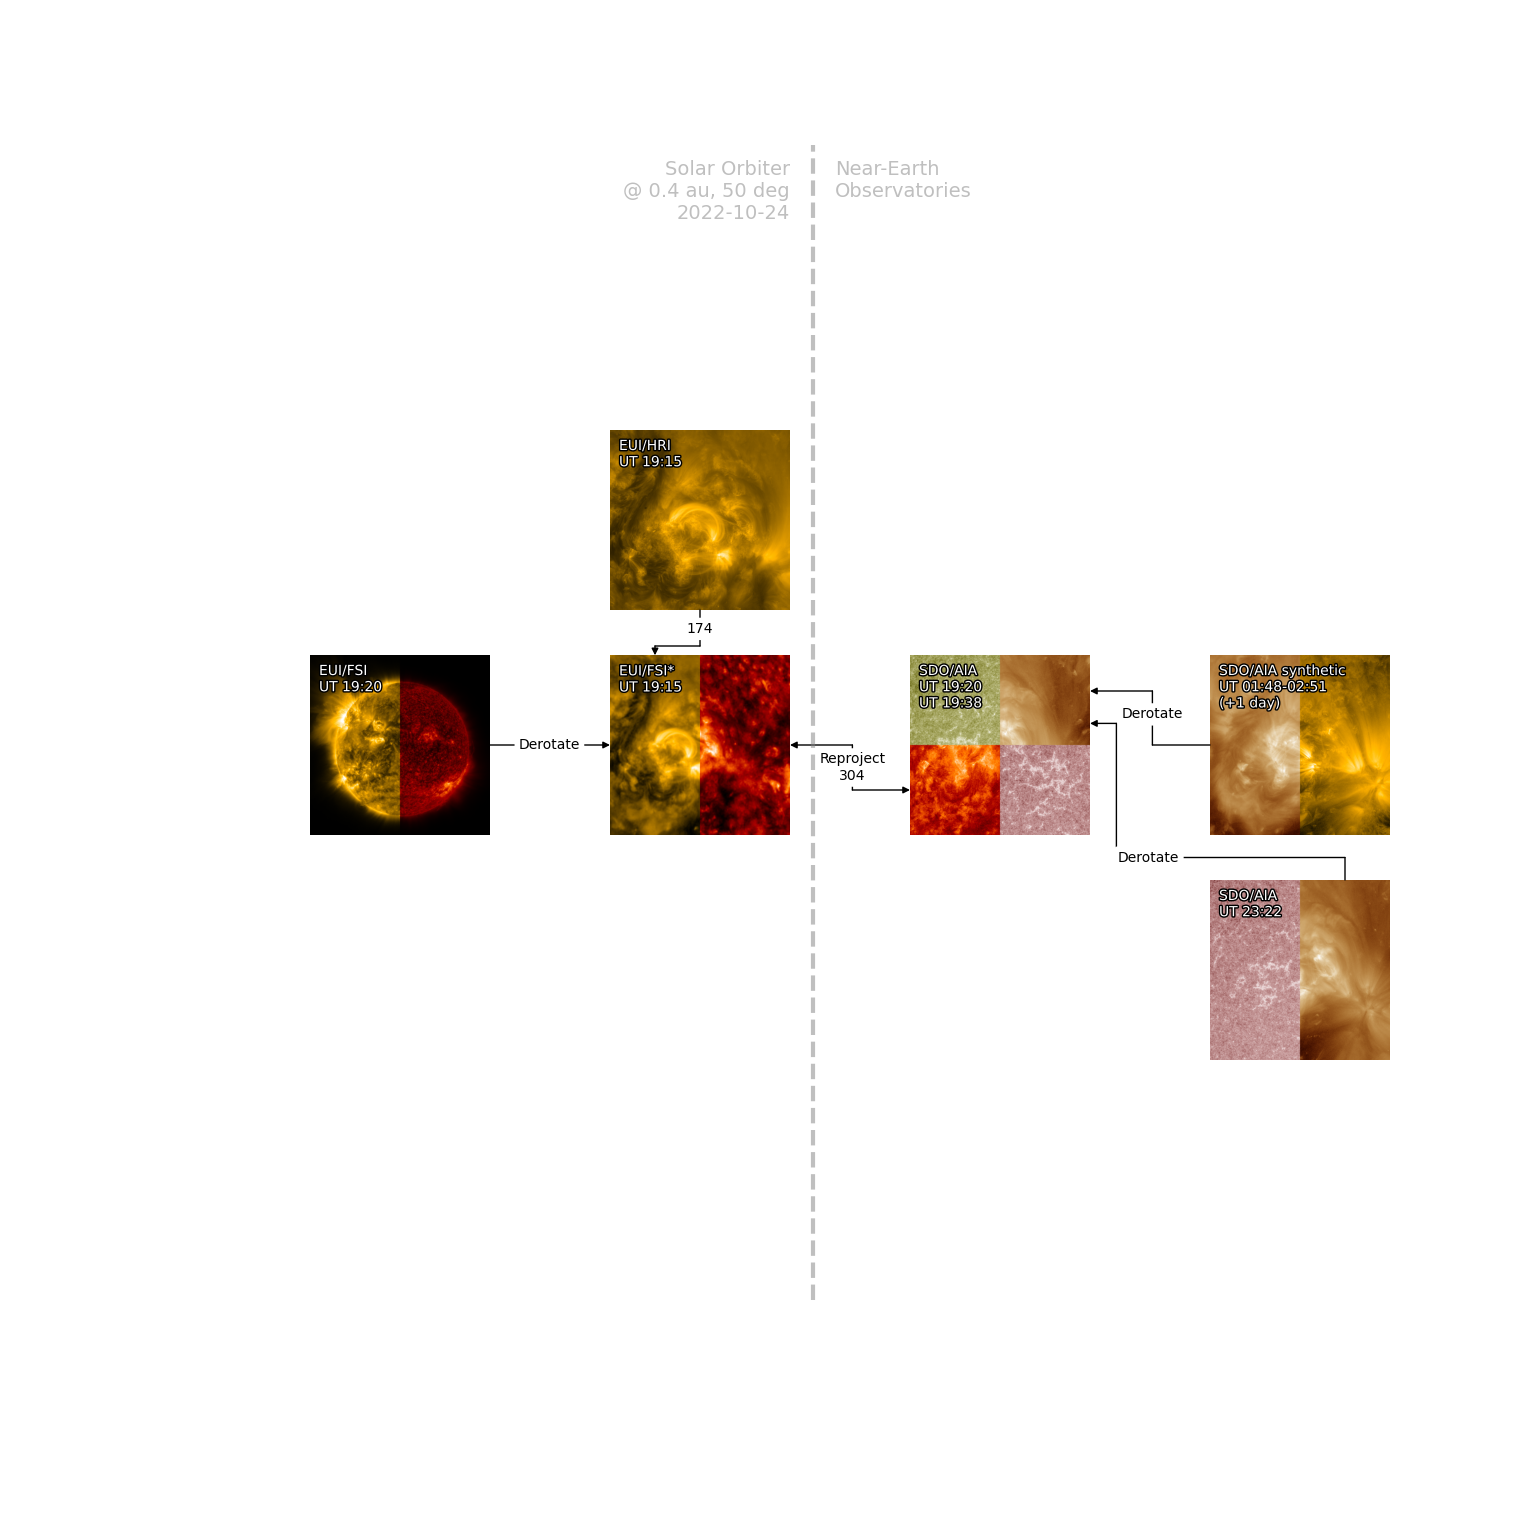

In [22]:
fig = plt.figure(figsize=(15,15))

ax_aia_1920 = fig.add_axes([0.6,0.45,0.12,0.12])
ax_fsi_1915 = fig.add_axes([0.4,0.45,0.12,0.12])
ax_hri_1915 = fig.add_axes([0.4,0.60,0.12,0.12])
ax_phi_1915 = fig.add_axes([0.4,0.3,0.12,0.12])
ax_hmi_1920 = fig.add_axes([0.6,0.3,0.12,0.12])
ax_spice_2315 = fig.add_axes([0.2,0.3,0.12,0.12])
ax_fsi_1920 = fig.add_axes([0.2,0.45,0.12,0.12])
ax_aia_0220 = fig.add_axes([0.8,0.45,0.12,0.12])
ax_aia_2322 = fig.add_axes([0.8,0.3,0.12,0.12])
ax_eis_0220 = fig.add_axes([0.8,0.6,0.12,0.12])
ax_eis_1938 = fig.add_axes([0.8,0.72,0.12,0.12])
ax_chase_1912 = fig.add_axes([0.6,0.73,0.12,0.12])
ax_visp_1915 = fig.add_axes([0.545,0.6,0.08,0.12])
ax_iris_2322 = fig.add_axes([0.8,0.15,0.12,0.12])
ax_iris_1920 = fig.add_axes([0.6,0.15,0.12,0.12])

ax_fig = fig.add_axes([0,0,1,1])
ax_fig.axis('off')

# ax_vbi_1900 = fig.add_axes([0.65,0.6,0.12,0.12])
# ax_vbi_1900.tick_params(which="major",axis="x",bottom=False,labelbottom=False)
# ax_vbi_1900.tick_params(which="major",axis="y",left=False,labelleft=False)
# ax_vbi_1900.imshow(vbi_combined)
# text_vbi_1900 = ax_vbi_1900.text(0.05,0.95,"DKIST/VBI\nUT 19:00\nJPEG Preview",fontsize=10,color='white',ha='left',va='top',
#         transform=ax_vbi_1900.transAxes)
# text_vbi_1900.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
#                           path_effects.Normal()])
# ax_vbi_1900.axis('off')


plot_map_pizza(ax_aia_1920, [aia_304_map_crop,aia_1700_map_crop,aia_1600_map_crop,aia_193_map_crop,],
                xslice=[0,799], yslice=[200,999],text='SDO/AIA\nUT 19:20\nUT 19:38')

plot_map_pizza(ax_fsi_1915, [fsi_174_map_hri_time_shift_crop, fsi_304_map_hri_time_shift_crop],
                xslice=[0,299], yslice=[10,349],text='EUI/FSI*\nUT 19:15')

arrow_connect(ax_aia_1920, ax_fsi_1915, [0,-0.32,-0.32,1], [0.25,0.25,0.5,0.5], [-0.32,0.375], 'Reproject\n304', color='black',
                textrotation=0.,arrow_1=True, arrow_2=True)

plot_map_pizza(ax_hri_1915, [hri_174_map_shifted_toaia],
                text='EUI/HRI\nUT 19:15')

arrow_connect(ax_hri_1915, ax_fsi_1915, [0.5,0.5,0.25,0.25], [0,-0.2,-0.2,1], [0.5,-0.105], '174', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_phi_1915, [phi_los_map_shifted],
#                 text='PHI/HRT\nUT 19:15')

# plot_map_pizza(ax_hmi_1920, [hmi_los_map_crop], 
#                 text='SDO/HMI\nUT 19:20', norms=[ImageNormalize(vmin=-1000,vmax=1000)],
#                 cmaps=['hmimag'], xslice=[0,799], yslice=[200,999])

# arrow_connect(ax_hmi_1920, ax_aia_1920, [0.5,0.5], [1,0], [0.5,1.125], 'aia_prep', color='black',
#                 textrotation=0.,arrow_1=True, arrow_2=True)

# arrow_connect(ax_phi_1915, ax_hmi_1920, [1,0.], [0.5,0.5], [1.34,0.5], 'Reproject', color='black',
#                 textrotation=0.,arrow_1=True, arrow_2=True)

# plot_map_pizza(ax_spice_2315, [spice_NeVIII_velmap_derot_shift,spice_NeVIII_intmap_derot_shift],
#                 text='SPICE\nUT 23:15', xslice=[40,180], yslice=[45,185])

plot_map_pizza(ax_fsi_1920, [fsi_174_map, fsi_304_map],
                text='EUI/FSI\nUT 19:20', xslice=[500,1999], yslice=[700,2199])

arrow_connect(ax_fsi_1920, ax_fsi_1915, [1,0], [0.5,0.5], [1.33,0.5], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

# arrow_connect(ax_spice_2315, ax_fsi_1915, [1,1.35,1.35,0], [0.5,0.5,1.5,0.5-0.25], [1.35,1], 'Derotate\nNe VIII/174', color='black',
#                 textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_aia_0220, [aia_193_map_eis_crop, aia_171_map_eis_crop],
                text='SDO/AIA synthetic\nUT 01:48-02:51\n(+1 day)', xslice=[0,799], yslice=[200,999])

arrow_connect(ax_aia_0220, ax_aia_1920, [0,-0.32,-0.32,1], [0.5,0.5,0.8,0.8], [-0.32,0.67], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_aia_2322, [aia_1700_map_2322_crop,aia_193_map_2322_crop,],
                text='SDO/AIA\nUT 23:22', xslice=[0,799], yslice=[200,999])

arrow_connect(ax_aia_2322, ax_aia_1920, [0.75,0.75,-0.52,-0.52,1], [1,1.125,1.125,1.62+0.25,0.62], [-0.34,1.125], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_eis_0220, [eis_195_intmap_shift,eis_195_velmap_shift],
#                 text='EIS\nUT 02:20\n(+1 day)', xslice=[0,62], yslice=[200,453])

# arrow_connect(ax_eis_0220, ax_aia_0220, [0.25,0.25], [0,1], [0.25,-0.25/2.], '193/195', color='black',
#                 textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_eis_1938, [eis_hhflare_195_intmap_shift,eis_hhflare_195_velmap_shift],
#                 text='EIS\nUT 19:38\nFlare Scan')

# arrow_connect(ax_eis_1938, ax_aia_1920, [0,-0.12,-0.12,1], [0.5,0.5,-1.512,1], [-0.12,-1.265/2], '193/195', color='black',
#                 textrotation=90.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_chase_1912, [chase_halpha_core_map_align_shift,chase_halpha_line_width_map_align_shift],
#                 text='CHASE\nUT 19:12',xslice=[0,287],yslice=[0,287])

# arrow_connect(ax_chase_1912, ax_aia_1920, [0.31,0.31], [0,1], [0.31,-0.25-0.5], r'1600/H$\alpha$ core', color='black',
#                 textrotation=90.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_visp_1915, [dkist_fitv_tom_cont_int_map_shift,dkist_fitv_tom_btot_map_shift,
#                                 dkist_fitv_tom_DoppVel_map_shifted,dkist_ftiv_tom_theta_map_shifted_masked],
#                 text='DKIST/ViSP\nUT 19:15',xslice=[0,687],yslice=[500,2554])

# arrow_connect(ax_visp_1915, ax_aia_1920, [0.8,0.8,1.04,0.2], [0,-0.125,-0.125,1], [0.85,-0.115], r'$B_{\rm tot}$/1600', color='black',
#                 textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_iris_2322, [iris_1400_sji_2322_map_rotate_crop_shift,iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji,
#                                 iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji],
#                 text='IRIS/SJI&SPEC\nRaster\nUT 23:22',xslice=[50,445],yslice=[50,445])

# arrow_connect(ax_iris_2322, ax_aia_2322, [0.25,0.25], [1,0], [0.25,1.11], r'1400/1700', color='black',
#                 textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_iris_1920, [iris_1400_sji_1920_map_rotate_shift],
#                 text='IRIS/SJI\nSit-n-Stare\nUT 19:20',xslice=[30,329],yslice=[30,329])      

# arrow_connect(ax_iris_1920, ax_aia_1920, [1,1.1,1.1,0.8,0.8], [0.5,0.5,2.35,2.35,0], [1.1,1.5], r'1400/1700', color='black',
#                 textrotation=90.,arrow_1=False, arrow_2=True)  

ax_fig.axvline(0.535,0.14,0.91,linestyle='--',color='grey',alpha=0.5,linewidth=3)
ax_fig.text(0.55,0.9,"Near-Earth\nObservatories",fontsize=14,color='grey',ha='left',va='top',
                alpha=0.5,transform=ax_fig.transAxes)

ax_fig.text(0.52,0.9,"Solar Orbiter\n@ 0.4 au, 50 deg\n2022-10-24",fontsize=14,color='grey',ha='right',va='top',
                alpha=0.5,transform=ax_fig.transAxes)

for ax_ in (ax_aia_1920,ax_fsi_1915,ax_hri_1915,ax_phi_1915,ax_hmi_1920,ax_spice_2315,ax_fsi_1920,
            ax_aia_0220,ax_aia_2322,ax_eis_0220,ax_eis_1938,ax_chase_1912,ax_visp_1915,ax_iris_2322,ax_iris_1920):
    ax_.axis('off')

plt.savefig(fname="../../figs/mindmaps/SolO_SDO_Hinode_DKIST_1024_real_0.pdf",dpi=144,bbox_inches=transforms.Bbox([[2.9,2],[14,13.7]]),pad_inches=0.)
plt.savefig(fname="../../figs/mindmaps/SolO_SDO_Hinode_DKIST_1024_real_0.png",dpi=300,bbox_inches=transforms.Bbox([[2.9,2],[14,13.7]]),pad_inches=0.)

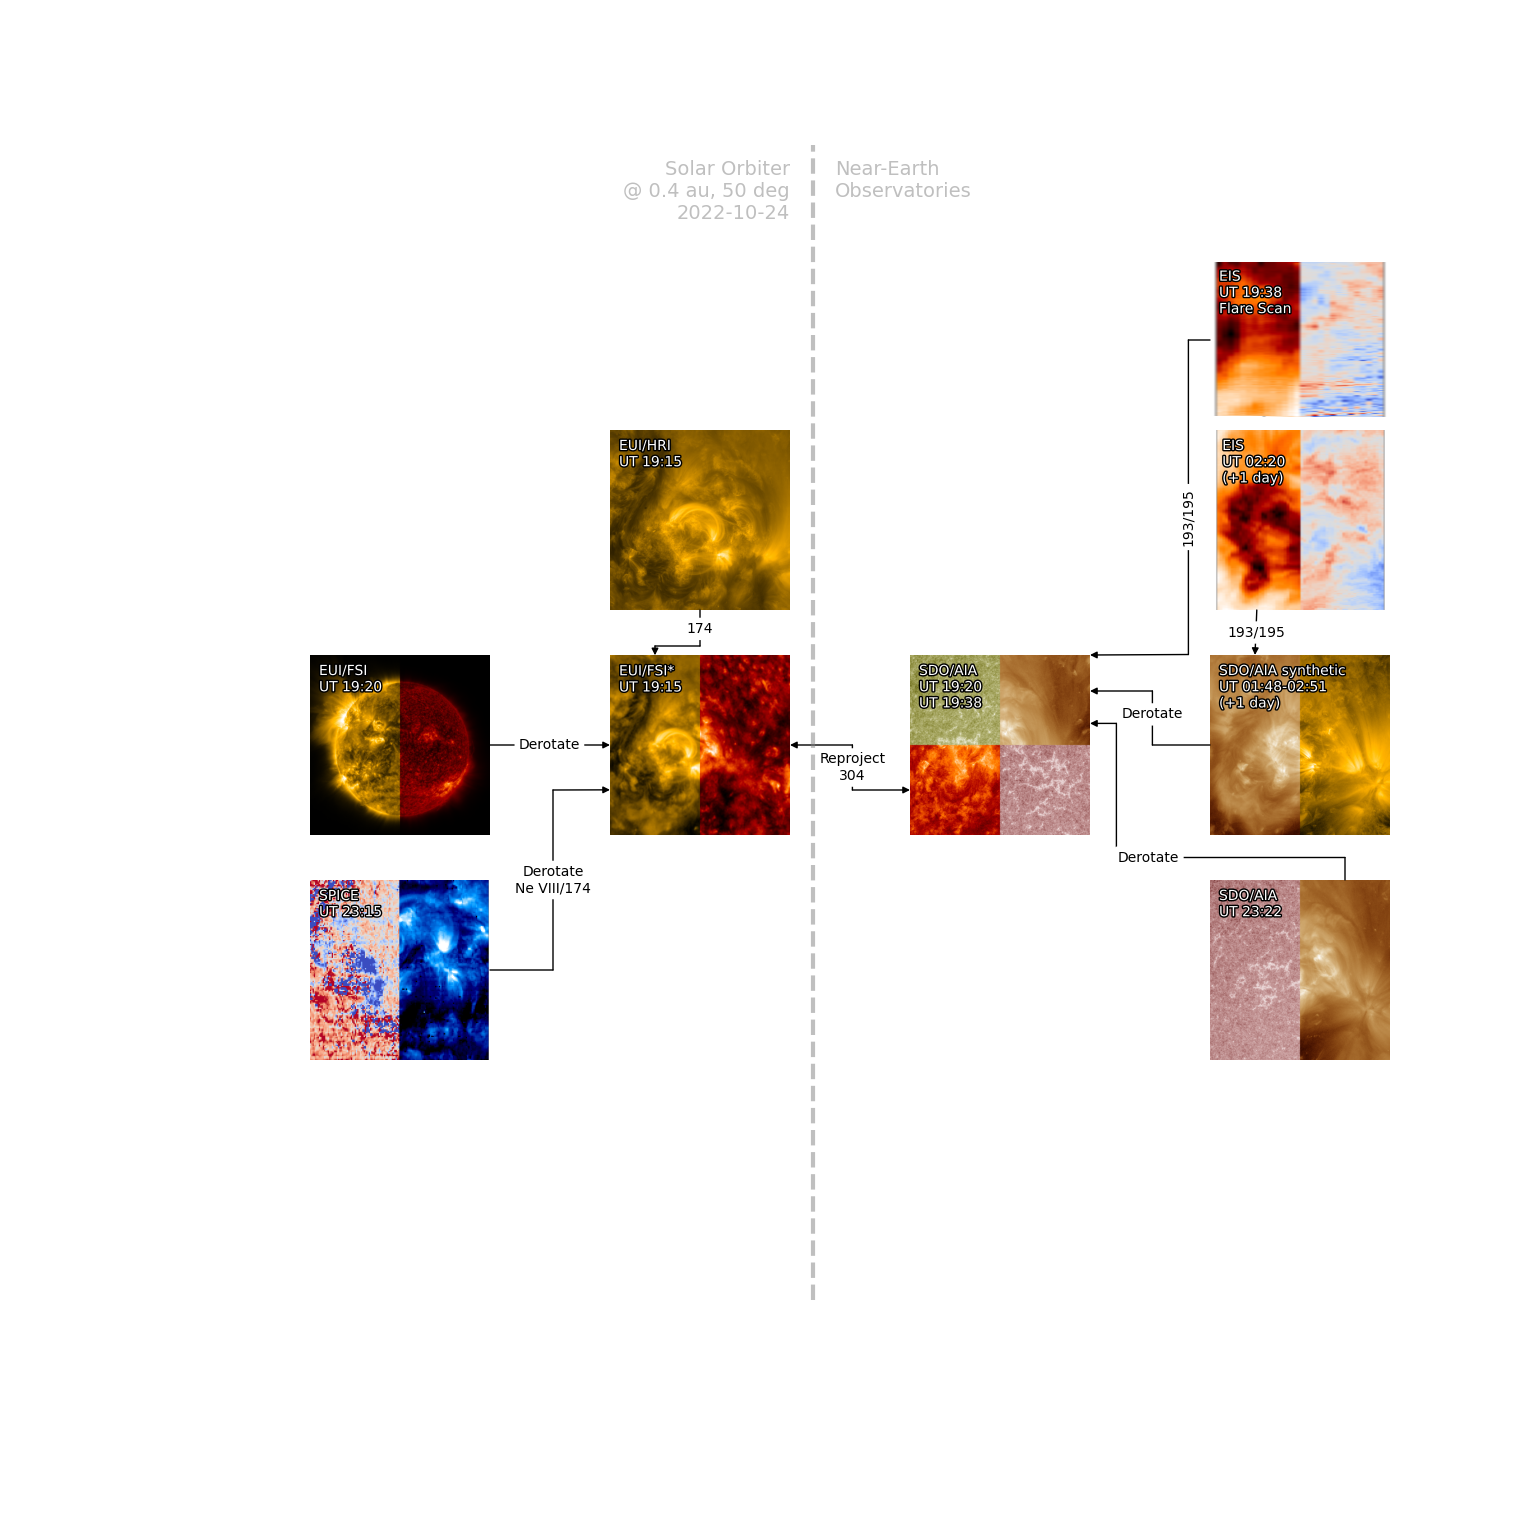

In [23]:
fig = plt.figure(figsize=(15,15))

ax_aia_1920 = fig.add_axes([0.6,0.45,0.12,0.12])
ax_fsi_1915 = fig.add_axes([0.4,0.45,0.12,0.12])
ax_hri_1915 = fig.add_axes([0.4,0.60,0.12,0.12])
ax_phi_1915 = fig.add_axes([0.4,0.3,0.12,0.12])
ax_hmi_1920 = fig.add_axes([0.6,0.3,0.12,0.12])
ax_spice_2315 = fig.add_axes([0.2,0.3,0.12,0.12])
ax_fsi_1920 = fig.add_axes([0.2,0.45,0.12,0.12])
ax_aia_0220 = fig.add_axes([0.8,0.45,0.12,0.12])
ax_aia_2322 = fig.add_axes([0.8,0.3,0.12,0.12])
ax_eis_0220 = fig.add_axes([0.8,0.6,0.12,0.12])
ax_eis_1938 = fig.add_axes([0.8,0.72,0.12,0.12])
ax_chase_1912 = fig.add_axes([0.6,0.73,0.12,0.12])
ax_visp_1915 = fig.add_axes([0.545,0.6,0.08,0.12])
ax_iris_2322 = fig.add_axes([0.8,0.15,0.12,0.12])
ax_iris_1920 = fig.add_axes([0.6,0.15,0.12,0.12])

ax_fig = fig.add_axes([0,0,1,1])
ax_fig.axis('off')

# ax_vbi_1900 = fig.add_axes([0.65,0.6,0.12,0.12])
# ax_vbi_1900.tick_params(which="major",axis="x",bottom=False,labelbottom=False)
# ax_vbi_1900.tick_params(which="major",axis="y",left=False,labelleft=False)
# ax_vbi_1900.imshow(vbi_combined)
# text_vbi_1900 = ax_vbi_1900.text(0.05,0.95,"DKIST/VBI\nUT 19:00\nJPEG Preview",fontsize=10,color='white',ha='left',va='top',
#         transform=ax_vbi_1900.transAxes)
# text_vbi_1900.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
#                           path_effects.Normal()])
# ax_vbi_1900.axis('off')


plot_map_pizza(ax_aia_1920, [aia_304_map_crop,aia_1700_map_crop,aia_1600_map_crop,aia_193_map_crop,],
                xslice=[0,799], yslice=[200,999],text='SDO/AIA\nUT 19:20\nUT 19:38')

plot_map_pizza(ax_fsi_1915, [fsi_174_map_hri_time_shift_crop, fsi_304_map_hri_time_shift_crop],
                xslice=[0,299], yslice=[10,349],text='EUI/FSI*\nUT 19:15')

arrow_connect(ax_aia_1920, ax_fsi_1915, [0,-0.32,-0.32,1], [0.25,0.25,0.5,0.5], [-0.32,0.375], 'Reproject\n304', color='black',
                textrotation=0.,arrow_1=True, arrow_2=True)

plot_map_pizza(ax_hri_1915, [hri_174_map_shifted_toaia],
                text='EUI/HRI\nUT 19:15')

arrow_connect(ax_hri_1915, ax_fsi_1915, [0.5,0.5,0.25,0.25], [0,-0.2,-0.2,1], [0.5,-0.105], '174', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_phi_1915, [phi_los_map_shifted],
#                 text='PHI/HRT\nUT 19:15')

# plot_map_pizza(ax_hmi_1920, [hmi_los_map_crop], 
#                 text='SDO/HMI\nUT 19:20', norms=[ImageNormalize(vmin=-1000,vmax=1000)],
#                 cmaps=['hmimag'], xslice=[0,799], yslice=[200,999])

# arrow_connect(ax_hmi_1920, ax_aia_1920, [0.5,0.5], [1,0], [0.5,1.125], 'aia_prep', color='black',
#                 textrotation=0.,arrow_1=True, arrow_2=True)

# arrow_connect(ax_phi_1915, ax_hmi_1920, [1,0.], [0.5,0.5], [1.34,0.5], 'Reproject', color='black',
#                 textrotation=0.,arrow_1=True, arrow_2=True)

plot_map_pizza(ax_spice_2315, [spice_NeVIII_velmap_derot_shift,spice_NeVIII_intmap_derot_shift],
                text='SPICE\nUT 23:15', xslice=[40,180], yslice=[45,185])

plot_map_pizza(ax_fsi_1920, [fsi_174_map, fsi_304_map],
                text='EUI/FSI\nUT 19:20', xslice=[500,1999], yslice=[700,2199])

arrow_connect(ax_fsi_1920, ax_fsi_1915, [1,0], [0.5,0.5], [1.33,0.5], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

arrow_connect(ax_spice_2315, ax_fsi_1915, [1,1.35,1.35,0], [0.5,0.5,1.5,0.5-0.25], [1.35,1], 'Derotate\nNe VIII/174', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_aia_0220, [aia_193_map_eis_crop, aia_171_map_eis_crop],
                text='SDO/AIA synthetic\nUT 01:48-02:51\n(+1 day)', xslice=[0,799], yslice=[200,999])

arrow_connect(ax_aia_0220, ax_aia_1920, [0,-0.32,-0.32,1], [0.5,0.5,0.8,0.8], [-0.32,0.67], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_aia_2322, [aia_1700_map_2322_crop,aia_193_map_2322_crop,],
                text='SDO/AIA\nUT 23:22', xslice=[0,799], yslice=[200,999])

arrow_connect(ax_aia_2322, ax_aia_1920, [0.75,0.75,-0.52,-0.52,1], [1,1.125,1.125,1.62+0.25,0.62], [-0.34,1.125], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_eis_0220, [eis_195_intmap_shift,eis_195_velmap_shift],
                text='EIS\nUT 02:20\n(+1 day)', xslice=[0,62], yslice=[200,453])

arrow_connect(ax_eis_0220, ax_aia_0220, [0.25,0.25], [0,1], [0.25,-0.25/2.], '193/195', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_eis_1938, [eis_hhflare_195_intmap_shift,eis_hhflare_195_velmap_shift],
                text='EIS\nUT 19:38\nFlare Scan')

arrow_connect(ax_eis_1938, ax_aia_1920, [0,-0.12,-0.12,1], [0.5,0.5,-1.512,1], [-0.12,-1.265/2], '193/195', color='black',
                textrotation=90.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_chase_1912, [chase_halpha_core_map_align_shift,chase_halpha_line_width_map_align_shift],
#                 text='CHASE\nUT 19:12',xslice=[0,287],yslice=[0,287])

# arrow_connect(ax_chase_1912, ax_aia_1920, [0.31,0.31], [0,1], [0.31,-0.25-0.5], r'1600/H$\alpha$ core', color='black',
#                 textrotation=90.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_visp_1915, [dkist_fitv_tom_cont_int_map_shift,dkist_fitv_tom_btot_map_shift,
#                                 dkist_fitv_tom_DoppVel_map_shifted,dkist_ftiv_tom_theta_map_shifted_masked],
#                 text='DKIST/ViSP\nUT 19:15',xslice=[0,687],yslice=[500,2554])

# arrow_connect(ax_visp_1915, ax_aia_1920, [0.8,0.8,1.04,0.2], [0,-0.125,-0.125,1], [0.85,-0.115], r'$B_{\rm tot}$/1600', color='black',
#                 textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_iris_2322, [iris_1400_sji_2322_map_rotate_crop_shift,iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji,
#                                 iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji],
#                 text='IRIS/SJI&SPEC\nRaster\nUT 23:22',xslice=[50,445],yslice=[50,445])

# arrow_connect(ax_iris_2322, ax_aia_2322, [0.25,0.25], [1,0], [0.25,1.11], r'1400/1700', color='black',
#                 textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_iris_1920, [iris_1400_sji_1920_map_rotate_shift],
#                 text='IRIS/SJI\nSit-n-Stare\nUT 19:20',xslice=[30,329],yslice=[30,329])      

# arrow_connect(ax_iris_1920, ax_aia_1920, [1,1.1,1.1,0.8,0.8], [0.5,0.5,2.35,2.35,0], [1.1,1.5], r'1400/1700', color='black',
#                 textrotation=90.,arrow_1=False, arrow_2=True)  

ax_fig.axvline(0.535,0.14,0.91,linestyle='--',color='grey',alpha=0.5,linewidth=3)
ax_fig.text(0.55,0.9,"Near-Earth\nObservatories",fontsize=14,color='grey',ha='left',va='top',
                alpha=0.5,transform=ax_fig.transAxes)

ax_fig.text(0.52,0.9,"Solar Orbiter\n@ 0.4 au, 50 deg\n2022-10-24",fontsize=14,color='grey',ha='right',va='top',
                alpha=0.5,transform=ax_fig.transAxes)

for ax_ in (ax_aia_1920,ax_fsi_1915,ax_hri_1915,ax_phi_1915,ax_hmi_1920,ax_spice_2315,ax_fsi_1920,
            ax_aia_0220,ax_aia_2322,ax_eis_0220,ax_eis_1938,ax_chase_1912,ax_visp_1915,ax_iris_2322,ax_iris_1920):
    ax_.axis('off')

plt.savefig(fname="../../figs/mindmaps/SolO_SDO_Hinode_DKIST_1024_real_1.pdf",dpi=144,bbox_inches=transforms.Bbox([[2.9,2],[14,13.7]]),pad_inches=0.)
plt.savefig(fname="../../figs/mindmaps/SolO_SDO_Hinode_DKIST_1024_real_1.png",dpi=300,bbox_inches=transforms.Bbox([[2.9,2],[14,13.7]]),pad_inches=0.)

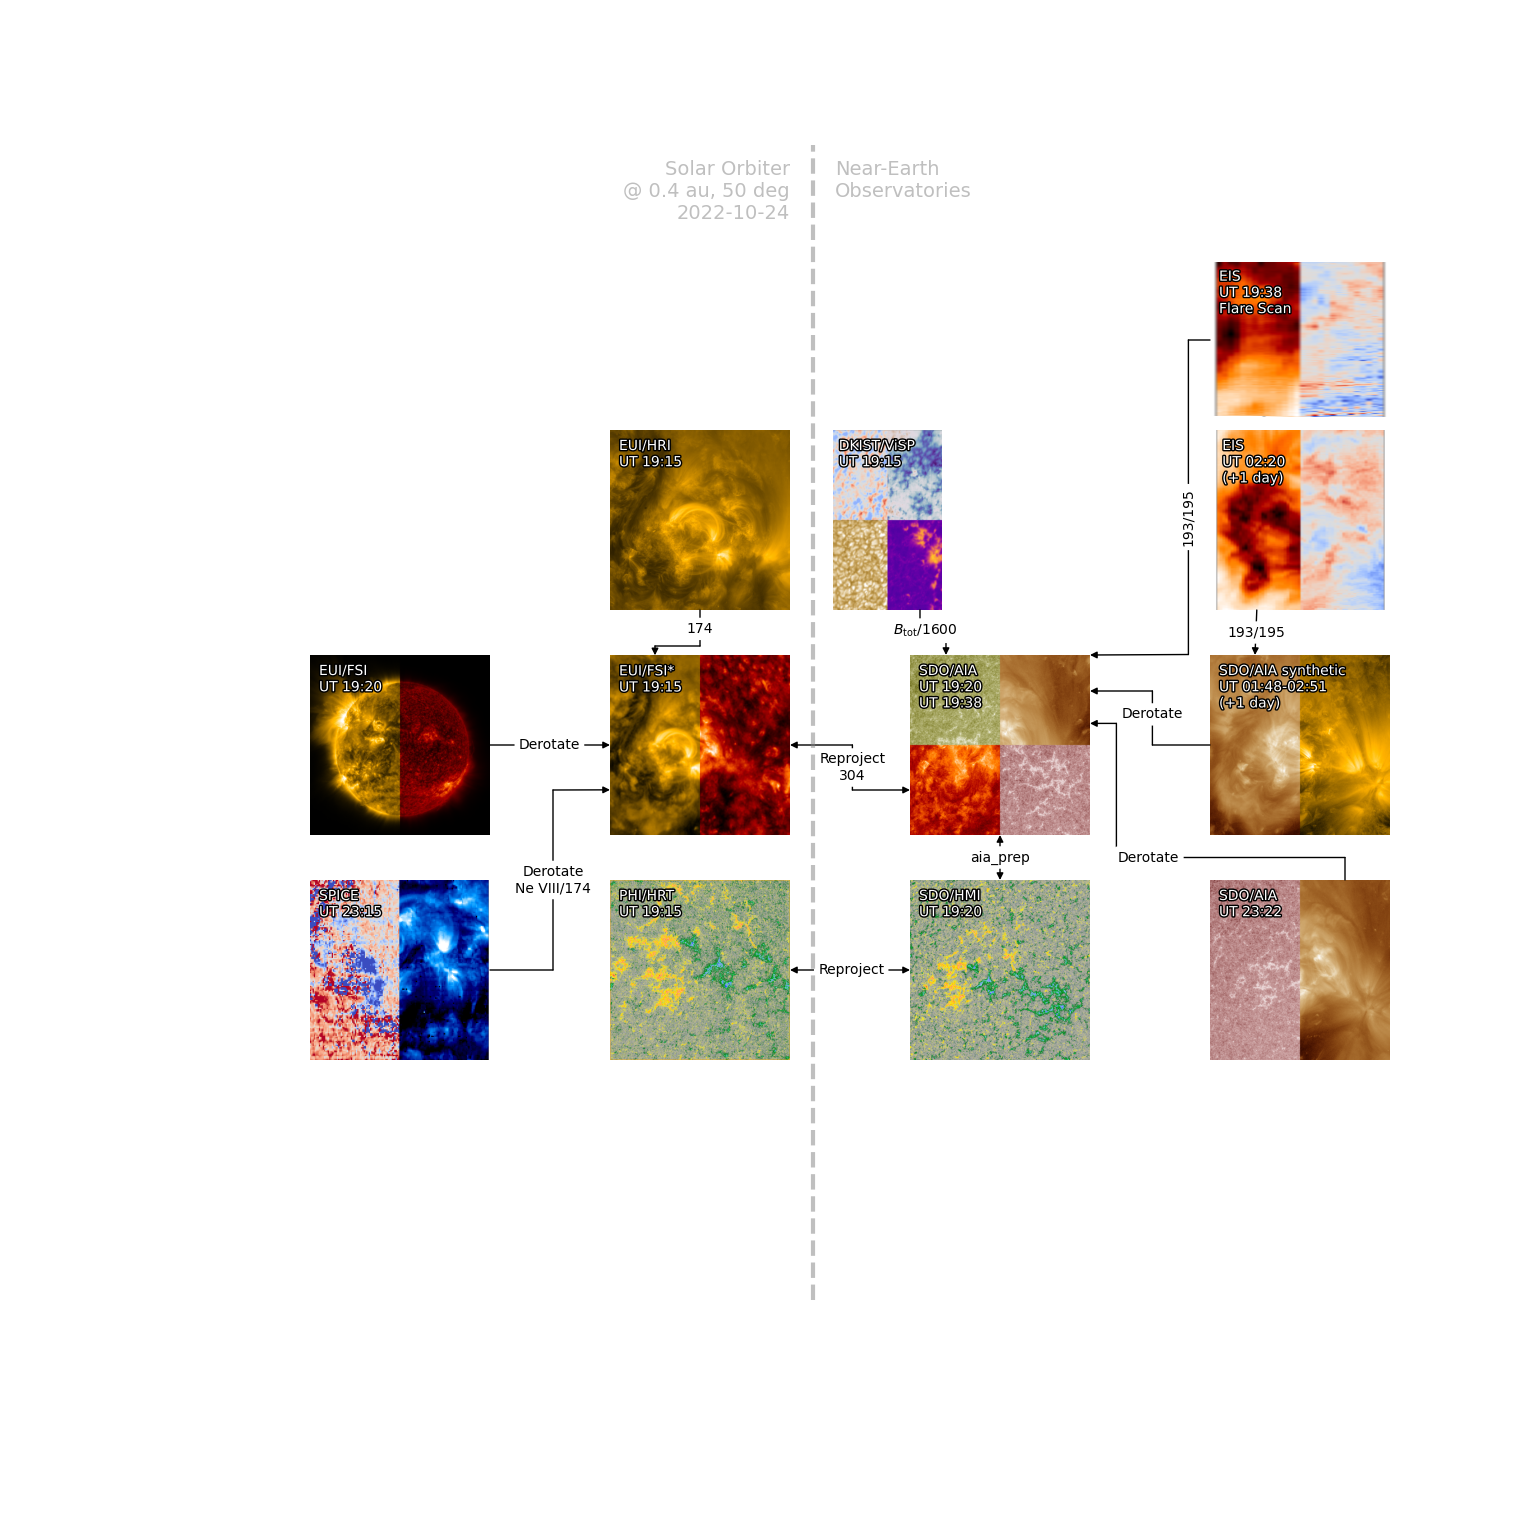

In [24]:
fig = plt.figure(figsize=(15,15))

ax_aia_1920 = fig.add_axes([0.6,0.45,0.12,0.12])
ax_fsi_1915 = fig.add_axes([0.4,0.45,0.12,0.12])
ax_hri_1915 = fig.add_axes([0.4,0.60,0.12,0.12])
ax_phi_1915 = fig.add_axes([0.4,0.3,0.12,0.12])
ax_hmi_1920 = fig.add_axes([0.6,0.3,0.12,0.12])
ax_spice_2315 = fig.add_axes([0.2,0.3,0.12,0.12])
ax_fsi_1920 = fig.add_axes([0.2,0.45,0.12,0.12])
ax_aia_0220 = fig.add_axes([0.8,0.45,0.12,0.12])
ax_aia_2322 = fig.add_axes([0.8,0.3,0.12,0.12])
ax_eis_0220 = fig.add_axes([0.8,0.6,0.12,0.12])
ax_eis_1938 = fig.add_axes([0.8,0.72,0.12,0.12])
ax_chase_1912 = fig.add_axes([0.6,0.73,0.12,0.12])
ax_visp_1915 = fig.add_axes([0.545,0.6,0.08,0.12])
ax_iris_2322 = fig.add_axes([0.8,0.15,0.12,0.12])
ax_iris_1920 = fig.add_axes([0.6,0.15,0.12,0.12])

ax_fig = fig.add_axes([0,0,1,1])
ax_fig.axis('off')

# ax_vbi_1900 = fig.add_axes([0.65,0.6,0.12,0.12])
# ax_vbi_1900.tick_params(which="major",axis="x",bottom=False,labelbottom=False)
# ax_vbi_1900.tick_params(which="major",axis="y",left=False,labelleft=False)
# ax_vbi_1900.imshow(vbi_combined)
# text_vbi_1900 = ax_vbi_1900.text(0.05,0.95,"DKIST/VBI\nUT 19:00\nJPEG Preview",fontsize=10,color='white',ha='left',va='top',
#         transform=ax_vbi_1900.transAxes)
# text_vbi_1900.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
#                           path_effects.Normal()])
# ax_vbi_1900.axis('off')


plot_map_pizza(ax_aia_1920, [aia_304_map_crop,aia_1700_map_crop,aia_1600_map_crop,aia_193_map_crop,],
                xslice=[0,799], yslice=[200,999],text='SDO/AIA\nUT 19:20\nUT 19:38')

plot_map_pizza(ax_fsi_1915, [fsi_174_map_hri_time_shift_crop, fsi_304_map_hri_time_shift_crop],
                xslice=[0,299], yslice=[10,349],text='EUI/FSI*\nUT 19:15')

arrow_connect(ax_aia_1920, ax_fsi_1915, [0,-0.32,-0.32,1], [0.25,0.25,0.5,0.5], [-0.32,0.375], 'Reproject\n304', color='black',
                textrotation=0.,arrow_1=True, arrow_2=True)

plot_map_pizza(ax_hri_1915, [hri_174_map_shifted_toaia],
                text='EUI/HRI\nUT 19:15')

arrow_connect(ax_hri_1915, ax_fsi_1915, [0.5,0.5,0.25,0.25], [0,-0.2,-0.2,1], [0.5,-0.105], '174', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_phi_1915, [phi_los_map_shifted],
                text='PHI/HRT\nUT 19:15')

plot_map_pizza(ax_hmi_1920, [hmi_los_map_crop], 
                text='SDO/HMI\nUT 19:20', norms=[ImageNormalize(vmin=-1000,vmax=1000)],
                cmaps=['hmimag'], xslice=[0,799], yslice=[200,999])

arrow_connect(ax_hmi_1920, ax_aia_1920, [0.5,0.5], [1,0], [0.5,1.125], 'aia_prep', color='black',
                textrotation=0.,arrow_1=True, arrow_2=True)

arrow_connect(ax_phi_1915, ax_hmi_1920, [1,0.], [0.5,0.5], [1.34,0.5], 'Reproject', color='black',
                textrotation=0.,arrow_1=True, arrow_2=True)

plot_map_pizza(ax_spice_2315, [spice_NeVIII_velmap_derot_shift,spice_NeVIII_intmap_derot_shift],
                text='SPICE\nUT 23:15', xslice=[40,180], yslice=[45,185])

plot_map_pizza(ax_fsi_1920, [fsi_174_map, fsi_304_map],
                text='EUI/FSI\nUT 19:20', xslice=[500,1999], yslice=[700,2199])

arrow_connect(ax_fsi_1920, ax_fsi_1915, [1,0], [0.5,0.5], [1.33,0.5], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

arrow_connect(ax_spice_2315, ax_fsi_1915, [1,1.35,1.35,0], [0.5,0.5,1.5,0.5-0.25], [1.35,1], 'Derotate\nNe VIII/174', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_aia_0220, [aia_193_map_eis_crop, aia_171_map_eis_crop],
                text='SDO/AIA synthetic\nUT 01:48-02:51\n(+1 day)', xslice=[0,799], yslice=[200,999])

arrow_connect(ax_aia_0220, ax_aia_1920, [0,-0.32,-0.32,1], [0.5,0.5,0.8,0.8], [-0.32,0.67], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_aia_2322, [aia_1700_map_2322_crop,aia_193_map_2322_crop,],
                text='SDO/AIA\nUT 23:22', xslice=[0,799], yslice=[200,999])

arrow_connect(ax_aia_2322, ax_aia_1920, [0.75,0.75,-0.52,-0.52,1], [1,1.125,1.125,1.62+0.25,0.62], [-0.34,1.125], 'Derotate', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_eis_0220, [eis_195_intmap_shift,eis_195_velmap_shift],
                text='EIS\nUT 02:20\n(+1 day)', xslice=[0,62], yslice=[200,453])

arrow_connect(ax_eis_0220, ax_aia_0220, [0.25,0.25], [0,1], [0.25,-0.25/2.], '193/195', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_eis_1938, [eis_hhflare_195_intmap_shift,eis_hhflare_195_velmap_shift],
                text='EIS\nUT 19:38\nFlare Scan')

arrow_connect(ax_eis_1938, ax_aia_1920, [0,-0.12,-0.12,1], [0.5,0.5,-1.512,1], [-0.12,-1.265/2], '193/195', color='black',
                textrotation=90.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_chase_1912, [chase_halpha_core_map_align_shift,chase_halpha_line_width_map_align_shift],
#                 text='CHASE\nUT 19:12',xslice=[0,287],yslice=[0,287])

# arrow_connect(ax_chase_1912, ax_aia_1920, [0.31,0.31], [0,1], [0.31,-0.25-0.5], r'1600/H$\alpha$ core', color='black',
#                 textrotation=90.,arrow_1=False, arrow_2=True)

plot_map_pizza(ax_visp_1915, [dkist_fitv_tom_cont_int_map_shift,dkist_fitv_tom_btot_map_shift,
                                dkist_fitv_tom_DoppVel_map_shifted,dkist_ftiv_tom_theta_map_shifted_masked],
                text='DKIST/ViSP\nUT 19:15',xslice=[0,687],yslice=[500,2554])

arrow_connect(ax_visp_1915, ax_aia_1920, [0.8,0.8,1.04,0.2], [0,-0.125,-0.125,1], [0.85,-0.115], r'$B_{\rm tot}$/1600', color='black',
                textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_iris_2322, [iris_1400_sji_2322_map_rotate_crop_shift,iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji,
#                                 iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji],
#                 text='IRIS/SJI&SPEC\nRaster\nUT 23:22',xslice=[50,445],yslice=[50,445])

# arrow_connect(ax_iris_2322, ax_aia_2322, [0.25,0.25], [1,0], [0.25,1.11], r'1400/1700', color='black',
#                 textrotation=0.,arrow_1=False, arrow_2=True)

# plot_map_pizza(ax_iris_1920, [iris_1400_sji_1920_map_rotate_shift],
#                 text='IRIS/SJI\nSit-n-Stare\nUT 19:20',xslice=[30,329],yslice=[30,329])      

# arrow_connect(ax_iris_1920, ax_aia_1920, [1,1.1,1.1,0.8,0.8], [0.5,0.5,2.35,2.35,0], [1.1,1.5], r'1400/1700', color='black',
#                 textrotation=90.,arrow_1=False, arrow_2=True)  

ax_fig.axvline(0.535,0.14,0.91,linestyle='--',color='grey',alpha=0.5,linewidth=3)
ax_fig.text(0.55,0.9,"Near-Earth\nObservatories",fontsize=14,color='grey',ha='left',va='top',
                alpha=0.5,transform=ax_fig.transAxes)

ax_fig.text(0.52,0.9,"Solar Orbiter\n@ 0.4 au, 50 deg\n2022-10-24",fontsize=14,color='grey',ha='right',va='top',
                alpha=0.5,transform=ax_fig.transAxes)

for ax_ in (ax_aia_1920,ax_fsi_1915,ax_hri_1915,ax_phi_1915,ax_hmi_1920,ax_spice_2315,ax_fsi_1920,
            ax_aia_0220,ax_aia_2322,ax_eis_0220,ax_eis_1938,ax_chase_1912,ax_visp_1915,ax_iris_2322,ax_iris_1920):
    ax_.axis('off')

plt.savefig(fname="../../figs/mindmaps/SolO_SDO_Hinode_DKIST_1024_real_2.pdf",dpi=144,bbox_inches=transforms.Bbox([[2.9,2],[14,13.7]]),pad_inches=0.)
plt.savefig(fname="../../figs/mindmaps/SolO_SDO_Hinode_DKIST_1024_real_2.png",dpi=300,bbox_inches=transforms.Bbox([[2.9,2],[14,13.7]]),pad_inches=0.)